In [1]:
import time

from data.swarmset import SwarmDataset, DataBuilder

baseline_data = DataBuilder("data/new")
baseline_data.create()
baseline_data.evolution.close()

similar_data = DataBuilder("data/similar", is_similar=True)
similar_data.create()
similar_data.evolution.close()

anti_data = DataBuilder("data/anti", is_anti=True)
anti_data.create()
anti_data.evolution.close()

pygame 2.1.2 (SDL 2.0.16, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
0.0% Complete
0.20833333333333334% Complete
0.4166666666666667% Complete
0.625% Complete
0.8333333333333334% Complete
1.0416666666666667% Complete
1.25% Complete
1.4583333333333333% Complete
1.6666666666666667% Complete
1.875% Complete
2.0833333333333335% Complete
2.2916666666666665% Complete
2.5% Complete
2.7083333333333335% Complete
2.9166666666666665% Complete
3.125% Complete
3.3333333333333335% Complete
3.5416666666666665% Complete
3.75% Complete
3.9583333333333335% Complete
4.166666666666667% Complete
4.375% Complete
4.583333333333333% Complete
4.791666666666667% Complete
5.0% Complete
5.208333333333333% Complete
5.416666666666667% Complete
5.625% Complete
5.833333333333333% Complete
6.041666666666667% Complete
6.25% Complete
6.458333333333333% Complete
6.666666666666667% Complete
6.875% Complete
7.083333333333333% Complete
7.291666666666667% Complete
7.5% Complete
7.70

In [2]:
# from data.swarmset import SwarmDataset, DataBuilder
# from networks.encoder import BehaviorAutoEncoder
# import numpy as np
# import cv2
# import torch
#
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dataset = SwarmDataset("data/new")
#
# encoder = BehaviorAutoEncoder()
# encoder.load_model("cp_C-90")
# encoder.to(device)
# encoder.eval()
#
# def resizeInput(X):
#     frame = X.astype(np.uint8)
#     resized = cv2.resize(frame, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
#     return resized
#
# def imgToEncoded(X):
#     X = torch.Tensor(resizeInput(X)).to(device)
#     X = torch.reshape(X, (1, 200*200))
#     f_X = encoder.encoded(X).to(device)
#     return X, f_X
#
# def imgToDecoded(X):
#     X = torch.Tensor(resizeInput(X)).to(device)
#     X = torch.reshape(X, (1, 200*200))
#     d = encoder(X).to(device)
#     d = torch.reshape(d, (200, 200))
#     return X, d
#
# def encode_dataset(dataset):
#     print("Encoding Dataset!")
#     for i, (image, genome, behavior, _, _, _, _) in enumerate(dataset):
#         _, encoded_val = imgToEncoded(image)
#         encoded_val = encoded_val.squeeze(0).cpu().detach().numpy()
#         _, decoded = imgToDecoded(image)
#         decoded = decoded.cpu().detach().numpy()
#         dataset.add_rank(i, encoded_val, is_array=True)
#         dataset.add_image(i, decoded)
#     dataset.set_rank(1)
#
# baseline_data = SwarmDataset("data/new")
# anti_data = SwarmDataset("data/anti")
# similar_data = SwarmDataset("data/similar")
#
# encode_dataset(baseline_data)
# encode_dataset(anti_data)
# encode_dataset(similar_data)
#
# print("Done!")

Encoding Dataset!
Encoding Dataset!
Encoding Dataset!
Done!


# Embed into Latent Space

In [3]:
from networks.embedding import NoveltyEmbedding
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = NoveltyEmbedding().to(device)
print(network)

NoveltyEmbedding(
  (s1): Sequential(
    (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [12]:
def network_from_numpy(network, anchor_img, pos_img, neg_img):
    anchor_input = torch.from_numpy(anchor_img).to(device).float()
    pos_input = torch.from_numpy(pos_img).to(device).float()
    neg_input = torch.from_numpy(neg_img).to(device).float()

    anchor_out = network(anchor_input.unsqueeze(0))
    pos_out = network(pos_input.unsqueeze(0))
    neg_out = network(neg_input.unsqueeze(0))
    return anchor_out, pos_out, neg_out

In [13]:
class DataAggregationArchive:
    def __init__(self):
        self.archive = np.array([[]])

    def append(self, anchor, pos, neg):
        if len(self.archive[0]) == 0:
            self.archive = np.array([[anchor, pos, neg]])
        else:
            self.archive = np.concatenate((self.archive, np.array([[anchor, pos, neg]])))

    def __len__(self):
        return len(self.archive)

    def __getitem__(self, item):
        return self.archive[item][0], self.archive[item][1], self.archive[item][2]

In [14]:
# Human in the Loop
from sklearn.manifold import TSNE
import torch
from sklearn_extra.cluster import KMedoids
from ui.class_similarity import SimilarityGUI

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CLUSTERS = 8
def humanInput(anchor_dataset, network, optim, loss_fn, data_archive):

    # Begin by clustering all known embeddings into n classes.
    # Sample from these clusters and use the medoids as the anchors to hopefully scoop up hard samples.
    network.eval()
    archive = NoveltyArchive()
    for i, (anchor_encoding, genome, _, _, _, _, _) in enumerate(anchor_dataset):
        anchor_encoding = torch.from_numpy(anchor_encoding).to(device).float()
        embedding = network(anchor_encoding.unsqueeze(0)).squeeze(0).cpu().detach().numpy()
        archive.addToArchive(vec=embedding, genome=genome)

    kmedoids = KMedoids(n_clusters=CLUSTERS, random_state=0).fit(archive.archive)
    labels = kmedoids.labels_
    medoids = kmedoids.medoid_indices_

    network.train()
    user_help_cases, avg_loss, total_attempts = 0, 0, 0
    for cluster_class in range(CLUSTERS + 1):
        # Run Triplet Query on the Medoids themselves
        if cluster_class == 0:
            anchor_image = anchor_dataset[medoids[0]][0]
            samples = [medoids[med] for med in range(1, len(medoids))]
            subject_images = [anchor_dataset[sampled_class][0] for sampled_class in samples]
            ui_input = SimilarityGUI(anchor_image, subject_images)
            ui_input.run()
            user_responses = np.array(ui_input.assignment)
        else:
            cluster_class -= 1
            examples = np.where(labels == cluster_class)[0]
            samples = np.random.choice(examples, min(10, len(examples)))
            anchor_image = anchor_dataset[medoids[cluster_class]][0]
            subject_images = [anchor_dataset[sampled_class][0] for sampled_class in samples]
            ui_input = SimilarityGUI(anchor_image, subject_images)
            ui_input.run()
            user_responses = np.array(ui_input.assignment)

        for i in np.where(user_responses == 1)[0]:
            for j in np.where(user_responses == 0)[0]:
                anchor_image = anchor_dataset[medoids[cluster_class]][0]
                pos_image = anchor_dataset[samples[j]][0]
                neg_image = anchor_dataset[samples[i]][0]

                optimizer.zero_grad()
                anchor_out, pos_out, neg_out = network_from_numpy(network, anchor_image, pos_image, neg_image)

                loss = loss_fn(anchor_out, pos_out, neg_out)
                avg_loss += loss.item()
                total_attempts += 1
                print("User loss: ", loss)
                if loss.item() > 0:
                    loss.backward()
                    optim.step()
                    user_help_cases += 1
                    print("BACKPROP!")

                # Add to User Collected Archive
                data_archive.append(medoids[cluster_class], samples[j], samples[i])

    return user_help_cases, avg_loss / total_attempts

In [19]:
import torch
from data.swarmset import SwarmDataset, DataBuilder
from networks.embedding import NoveltyEmbedding
from generation.halted_evolution import HaltedEvolution
from NovelSwarmBehavior.novel_swarms.novelty.NoveltyArchive import NoveltyArchive
from NovelSwarmBehavior.novel_swarms.config.ResultsConfig import ResultsConfig
from NovelSwarmBehavior.novel_swarms.results.results import main as results
from NovelSwarmBehavior.novel_swarms.config.defaults import ConfigurationDefaults
from matplotlib import pyplot as plot
import numpy as np

TRAIN = True
CLUSTER_AND_DISPLAY = True
WRITE_OUT = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

network = NoveltyEmbedding().to(device)
anchor_dataset = SwarmDataset("data/new", rank=1)
anti_dataset = SwarmDataset("data/anti", rank=1)
similar_dataset = SwarmDataset("data/similar", rank=1)
evolution, screen = HaltedEvolution.defaultEvolver(steps=200, n_agents=10)

def shakeGenome(genome):
    return genome + (np.random.rand(len(genome)) * 0.01)

def antiGenome(genome):
    return -1 * shakeGenome(genome)

optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
loss_fn = torch.nn.TripletMarginLoss(margin=10)

EPOCHS = 10
self_l_hist = []
human_l_hist = [0.0 for _ in range(EPOCHS)]
HIL_archive = DataAggregationArchive()

if TRAIN:

    STOP_FLAG = False
    for epoch in range(EPOCHS):
        if STOP_FLAG:
            break

        loss_sum = 0
        total_loss = 0
        # Train on known archive
        print(f"User Data at size: {len(HIL_archive)}")
        if len(HIL_archive) < len(anchor_dataset) // 1.5:
            for i, (anchor_encoding, _, _, _, _, _, _) in enumerate(anchor_dataset):
                similar_encoding, _, _, _, _, _, _ = similar_dataset[i]
                anti_encoding, _, _, _, _, _, _ = anti_dataset[i]

                optimizer.zero_grad()
                anchor_out, pos_out, neg_out = network_from_numpy(network, anchor_encoding, similar_encoding, anti_encoding)

                loss = loss_fn(anchor_out, pos_out, neg_out)
                loss_sum += loss.item()
                if loss.item() > 0:
                    loss.backward()
                    optimizer.step()

        total_loss += i

        # Train on past user information
        for i, (anchor, pos, neg) in enumerate(HIL_archive):
            anchor_encoding = anchor_dataset[anchor][0]
            similar_encoding = anchor_dataset[pos][0]
            anti_encoding = anchor_dataset[neg][0]

            optimizer.zero_grad()
            anchor_out, pos_out, neg_out = network_from_numpy(network, anchor_encoding, similar_encoding, anti_encoding)
            loss = loss_fn(anchor_out, pos_out, neg_out)
            loss_sum += loss.item()
            if loss.item() > 0:
                loss.backward()
                optimizer.step()

        total_loss += i
        print(f"Average Loss: {loss_sum / (i + 1)}")
        self_l_hist.append(loss_sum / (i + 1))

        if len(self_l_hist) > 3 and self_l_hist[-1] == self_l_hist[-2] and self_l_hist[-2] == self_l_hist[-3]:
            loss_sum = 0

        EPSILON = -0.0001
        if loss_sum / (i + 1) < EPSILON:
            print("HIL TIME!")
            improvements, human_loss = humanInput(anchor_dataset, network, optimizer, loss_fn, HIL_archive)
            print(f"Improvement Count: {improvements}, loss: {human_loss}")
            human_l_hist[epoch] = human_loss

        print(f"Epoch: {epoch}")

if CLUSTER_AND_DISPLAY:
    network.eval()
    archive = NoveltyArchive()
    for i, (anchor_encoding, genome, _, _, _, _, _) in enumerate(anchor_dataset):
        anchor_encoding = torch.from_numpy(anchor_encoding).to(device).float()
        embedding = network(anchor_encoding.unsqueeze(0)).squeeze(0).cpu().detach().numpy()
        archive.addToArchive(vec=embedding, genome=genome)

    agent_config = ConfigurationDefaults.DIFF_DRIVE_AGENT
    world_config = ConfigurationDefaults.RECTANGULAR_WORLD
    world_config.addAgentConfig(agent_config)
    config = ResultsConfig(archive=archive, k_clusters=8, world_config=world_config, tsne_perplexity=20, tsne_early_exaggeration=2, skip_tsne=False)
    results(config)

evolution.close()

User Data at size: 1
Average Loss: 3.1395379175742466
Epoch: 0
User Data at size: 1
Average Loss: 1.1952121883630753
Epoch: 1
User Data at size: 1
Average Loss: 0.2992186109224955
Epoch: 2
User Data at size: 1
Average Loss: 0.11247298916180928
Epoch: 3
User Data at size: 1
Average Loss: 0.0
Epoch: 4
User Data at size: 1
Average Loss: 0.0
Epoch: 5
User Data at size: 1
Average Loss: 0.0
Epoch: 6
User Data at size: 1
Average Loss: 0.0
Epoch: 7
User Data at size: 1
Average Loss: 0.0
Epoch: 8
User Data at size: 1
Average Loss: 0.0
Epoch: 9
Starting TSNE!


/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


TSNE Finished!
Starting k-Medoids Clustering
k-Medoids Finished!


In [54]:
import time

WRITE_OUT = False
if WRITE_OUT:
    i = input("QUIT NOW IF YOU DONT WANT TO WRITE OUT")
    print("Writing in 3 seconds...")
    time.sleep(2)
    print("Writing in 1 seconds...")
    time.sleep(1)
    print("Writing out.")
    network.eval()
    for i, (anchor_encoding, _, _, _, _, _, _) in enumerate(anchor_dataset):
        anchor_encoding = torch.from_numpy(anchor_encoding).to(device).float()
        embedding = network(anchor_encoding.unsqueeze(0)).squeeze(0).cpu().detach().numpy()
        anchor_dataset.add_rank(i, embedding, is_array=True)
    anchor_dataset.set_rank(2)

# Clustering + Analysis

In [17]:
# Cluster over saved embeddings
from NovelSwarmBehavior.novel_swarms.novelty.NoveltyArchive import NoveltyArchive
from NovelSwarmBehavior.novel_swarms.config.ResultsConfig import ResultsConfig
from NovelSwarmBehavior.novel_swarms.results.results import main as results
from NovelSwarmBehavior.novel_swarms.config.defaults import ConfigurationDefaults
from data.swarmset import SwarmDataset, DataBuilder
archive = NoveltyArchive()
anchor_dataset = SwarmDataset("data/new", rank=2)
for i, (_, genome, _, _, _, embedding, _) in enumerate(anchor_dataset):
    archive.addToArchive(vec=embedding, genome=genome)

agent_config = ConfigurationDefaults.DIFF_DRIVE_AGENT
world_config = ConfigurationDefaults.RECTANGULAR_WORLD
world_config.addAgentConfig(agent_config)
config = ResultsConfig(archive=archive, k_clusters=7, world_config=world_config, tsne_perplexity=20, tsne_early_exaggeration=2, skip_tsne=False)
results(config)

Starting TSNE!


/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


TSNE Finished!
Starting k-Medoids Clustering
k-Medoids Finished!


KeyboardInterrupt: 

In [16]:
# Cluster over saved behaviors
archive = NoveltyArchive()
for i, (_, genome, behavior, _, _, _, _) in enumerate(anchor_dataset):
    archive.addToArchive(vec=behavior, genome=genome)

agent_config = ConfigurationDefaults.DIFF_DRIVE_AGENT
world_config = ConfigurationDefaults.RECTANGULAR_WORLD
world_config.addAgentConfig(agent_config)
config = ResultsConfig(archive=archive, k_clusters=7, world_config=world_config, tsne_perplexity=80, tsne_early_exaggeration=2, skip_tsne=False)
results(config)

Starting TSNE!


/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


TSNE Finished!
Starting k-Medoids Clustering
k-Medoids Finished!


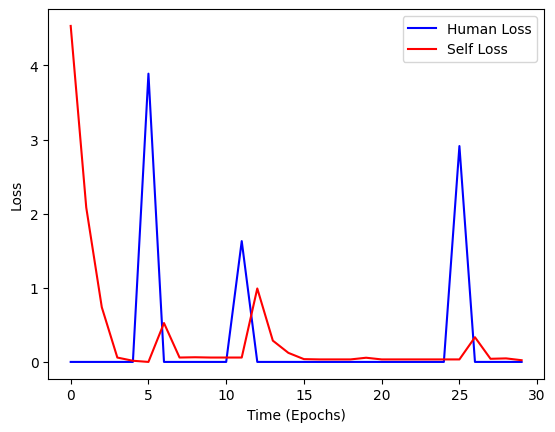

In [56]:
import matplotlib.pyplot as plt

plt.plot(human_l_hist, "b", label='Human Loss')
plt.plot(self_l_hist, "r", label='Self Loss')
plt.ylabel("Loss")
plt.xlabel("Time (Epochs)")
plt.legend()